In [58]:
%load_ext autoreload
%autoreload 2
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [102]:
from proj1_helpers import *
from implementations import *

DATA_TRAIN_PATH = '../data/train.csv' 
y_pre, tX_pre, ids = load_csv_data(DATA_TRAIN_PATH)

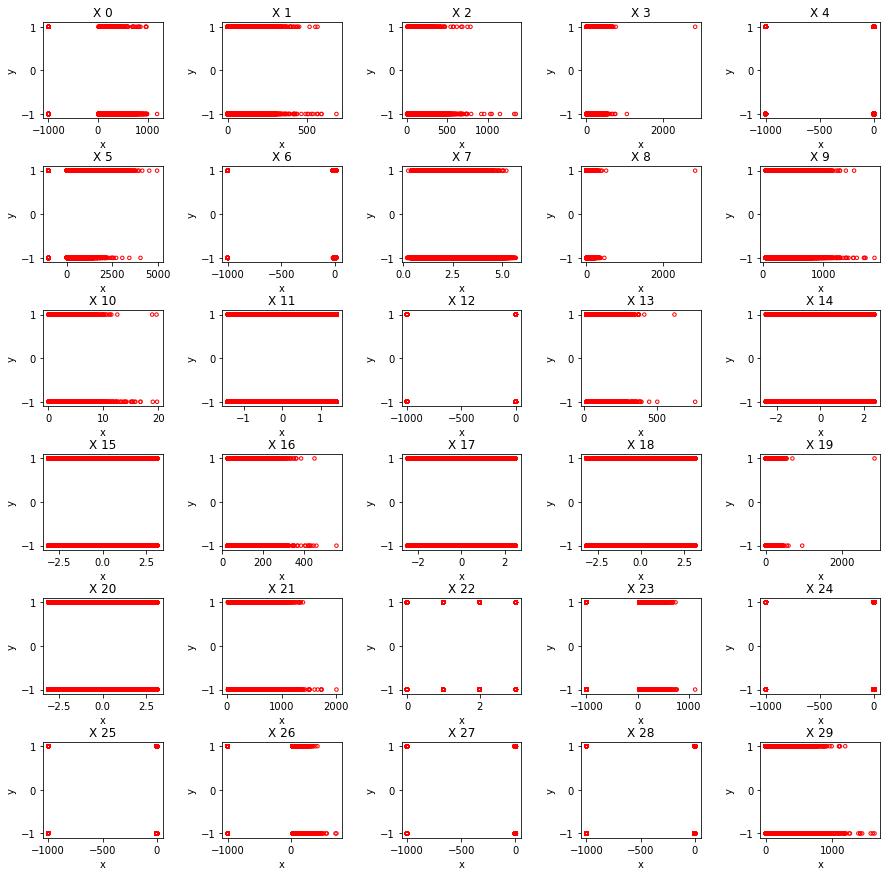

In [98]:
# Exploring data 
# define the structure of the figure
num_row = 6
num_col = 5
f, axs = plt.subplots(num_row, num_col,figsize=(15,15))

for i in range(tX_pre.shape[1]):
    ax = axs[i // num_col][i % num_col]
    ax.scatter(tX_pre[:,i], y_pre, color='b', s=12, facecolors='none', edgecolors='r')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("X " + str(i))

plt.subplots_adjust(wspace = .5, hspace = .5)


In [103]:
####################################
# Test LS 
# no pre-processing
# with or without bias
# on 20% test
####################################

x_tr, x_te, y_tr, y_te = split_data(tX_pre, y_pre, 0.8, seed=1)

degrees = [0, 1]

parameters_LS = { "model" : "LS" }

for d in degrees:    

    x_tr_p = build_poly(x_tr, d)
    x_te_p = build_poly(x_te, d)
        
    w_list, _ = least_squares(y_tr, x_tr_p)
    accuracies = compute_accuracy(x_te_p, y_te, w_list, parameters_LS)
    if d == 0:
        print("LS without bias, accuracy = ", accuracies)
    else :
        print("LS with bias, accuracy = ", accuracies)

# LS without bias, accuracy =  74.402
# LS with bias, accuracy =  74.468

LS without bias, accuracy =  74.402
LS with bias, accuracy =  74.468


## Preprocessing

In [100]:
#############################
#### Preprocessing
#############################


print("Before pre-processing")
print("tX shape :", tX_pre.shape)

tX_post = remove_categorical_feature(tX_pre)
tX_post = remove_aberrant_values(tX_post)
tX_post, _, _ = rescale_outliers(tX_post)
# tX_post = remove_correlation(tX_post, 0.95) # Not enough useful
tX_post, mean_x , std_x = standardize(tX_post)
y_post = y_pre.copy()

print("After pre processing")
print("tX shape :", tX_post.shape)





Before pre-processing
tX shape : (250000, 30)
After pre processing
tX shape : (250000, 29)


In [101]:
########################################
# LS 
# with pre-processing
# with or without bias
# on 20% test
########################################

x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, 0.8, seed=1)

degrees = [0,1]

parameters_LS = { "model" : "LS" }

for d in degrees:
    
    x_tr_p = build_poly(x_tr, d)
    x_te_p = build_poly(x_te, d)

        
    w_list, _ = least_squares(y_tr, x_tr_p)
    accuracy = compute_accuracy(x_te_p, y_te, w_list, parameters_LS)
    
    if d == 0:
        print("LS without bias, accuracy = ", accuracy)
    else :
        print("LS with bias, accuracy = ", accuracy)

# LS without bias, accuracy =  71.922
# LS with bias, accuracy =  75.05199999999999

LS without bias, accuracy =  71.922
LS with bias, accuracy =  75.05199999999999


## Do your thing crazy machine learning thing here :) ...

In [104]:
###################################
#### Innocent test (execution time)
###################################

import datetime
from implementations import *

initial_w = np.zeros(tX_post.shape[1])
max_iters = 500
ratio = 0.8
batch_size = 1

x_tr_ls, x_te_ls, y_tr_ls, y_te_ls = split_data(tX_pre, y_pre, ratio, seed=1)
param = {"model" : 'LS'}
start_time_ls = datetime.datetime.now()
w_ls, mse_ls = least_squares(y_tr_ls, x_tr_ls)
end_time_ls = datetime.datetime.now()
execution_time_ls = (end_time_ls - start_time_ls).total_seconds()


x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, ratio, seed=1)
param = {"model" : 'GD'}
gamma = 0.1
start_time_GD = datetime.datetime.now()
w_GD, loss_GD = least_squares_GD(y_tr, x_tr, initial_w, max_iters, gamma)
end_time_GD = datetime.datetime.now()
execution_time_GD = (end_time_GD - start_time_GD).total_seconds()

param = {"model" : 'SGD'}
gamma = 0.001
start_time_SGD = datetime.datetime.now()
w_SGD, loss_SGD = least_squares_SGD(y_tr, x_tr, initial_w, max_iters, batch_size, gamma)
end_time_SGD = datetime.datetime.now()
execution_time_SGD = (end_time_SGD - start_time_SGD).total_seconds()

print('LS : accuracy :', compute_accuracy(x_te_ls, y_te_ls, w_ls, param), 'execution time : ', execution_time_ls)
print('GD : accuracy :', compute_accuracy(x_te, y_te, w_GD, param), 'execution time : ', execution_time_GD)
print('SGD : accuracy :', compute_accuracy(x_te, y_te ,w_SGD, param), 'execution time : ', execution_time_SGD)

# LS : accuracy : 74.402 execution time :  0.009217
# GD : accuracy : 71.932 execution time :  6.594664
# SGD : accuracy : 70.194 execution time :  0.902316

LS : accuracy : 74.402 execution time :  0.0099
GD : accuracy : 71.932 execution time :  7.537539
SGD : accuracy : 70.194 execution time :  1.037379


## GD optimization with CV + hyperparam optimization

In [105]:
########################################
# GD : CV + hyperparam optimization
########################################
gammas = np.logspace(-3, -1, 3)
# Overflow with degree = 2
degrees = np.linspace(0, 1, 2)
max_iters = 500
k_fold = 5

parameters_GD = {
  "model": "GD",
  "param": [gammas, max_iters],
}


rmses_GD, accuracy_GD = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_GD, seed = 1)

# The best degree is 1.0  best parameter is 0.1  with RMSE =  0.8185333211260726 and accuracy =  75.00640000000001

Method =  GD
Degree =  0.0
Progress :  0.0  % 
Degree =  1.0
Progress :  50.0  % 
The method used is :  GD
The best degree is 1.0  best parameter is 0.1  with RMSE =  0.8185333211260705 and accuracy =  75.00640000000001


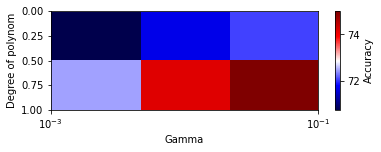

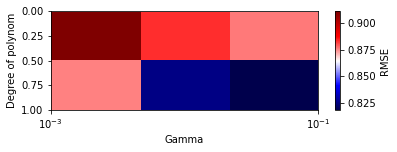

[[70.74   71.6768 72.0844]
 [72.4736 74.202  75.0064]]
[[0.911086   0.88394647 0.87693162]
 [0.87618139 0.82603342 0.81853332]]


In [106]:
plt.subplot(211)
plt.imshow(accuracy_GD, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gamma')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'Accuracy')
plt.show()

plt.subplot(212)
plt.imshow(rmses_GD, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gamma')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'RMSE')
plt.show()

print(accuracy_GD)
print(rmses_GD)


In [107]:
#################
# Test GD on 20%
#################


degree = 1
gamma = 0.1
max_iters = 1000


param = {
  "model": "GD",
}

x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, 0.8, seed=1)

x_tr_p = build_poly(x_tr, degree)
x_te_p = build_poly(x_te, degree)

initial_w = np.zeros(x_tr_p.shape[1])


w, _ = least_squares_GD(y_tr, x_tr_p, initial_w, max_iters, gamma)
accuracy = compute_accuracy(x_te_p, y_te, w, param)
rmse = np.sqrt(2 * compute_mse(y_te, x_te_p, w))

print("Test model : ", param["model"], "degree = ", degree, "param = ", gamma, "accuracy = ", accuracy, "RMSE =", rmse)

# Test model :  GD degree =  1 param =  0.1 accuracy =  75.062 RMSE = 0.8196278302206137

Test model :  GD degree =  1 param =  0.1 accuracy =  75.062 RMSE = 0.8196278302206137


## SGD optimization with CV + hyperparam optimization

In [108]:
########################################
# SGD : CV + hyperparam optimization
########################################
gammas = np.logspace(-4, -2, 3)
# After degree 2, overflow
degrees = np.linspace(1, 2, 2)
max_iters = 1000
k_fold = 5
batch_size = 1

parameters_SGD = {
  "model": "SGD",
  "param": [gammas, max_iters, batch_size],
}

rmses_SGD, accuracy_SGD = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_SGD, seed = 1)

# The best degree is 2.0  best parameter is 0.001  with RMSE =  0.8382226573967548 and accuracy =  75.7756

Method =  SGD
Degree =  1.0
Progress :  0.0  % 
Degree =  2.0
Progress :  50.0  % 
The method used is :  SGD
The best degree is 2.0  best parameter is 0.001  with RMSE =  0.8382226573967548 and accuracy =  75.7756


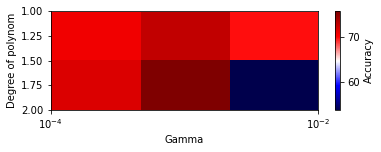

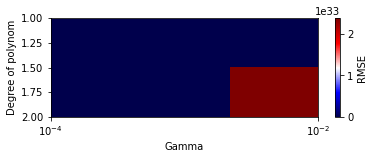

[[70.8244 72.8904 69.9452]
 [71.7904 75.7756 53.7396]]
[[9.52767009e-01 8.54945424e-01 9.22082004e-01]
 [8.76042495e-01 8.38222657e-01 2.38156667e+33]]


In [109]:
plt.subplot(211)
plt.imshow(accuracy_SGD, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gamma')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'Accuracy')
plt.show()

plt.subplot(212)
plt.imshow(rmses_SGD, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gamma')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'RMSE')
plt.show()

print(accuracy_SGD)
print(rmses_SGD)


In [110]:
#################
# Test SGD on 20%
#################


degree = 2
gamma = 0.001
max_iters = 1000
batch_size = 1


param = { "model" : "SGD" }

x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, 0.8, seed=1)

x_tr_p = build_poly(x_tr, degree)
x_te_p = build_poly(x_te, degree)

initial_w = np.zeros(x_tr_p.shape[1])

w, _ = least_squares_SGD(y_tr, x_tr_p, initial_w, max_iters, batch_size, gamma)
accuracy = compute_accuracy(x_te_p, y_te, w, param)
rmse = np.sqrt(2 * compute_mse(y_te, x_te_p, w))

print("Test model : ", param["model"], "degree = ", degree, "param = ", gamma, "accuracy = ", accuracy, "RMSE =", rmse)

# Test model :  SGD degree =  2 param =  0.001 accuracy =  76.254 RMSE = 0.8161253264120317


Test model :  SGD degree =  2 param =  0.001 accuracy =  76.254 RMSE = 0.8161253264120317


## LS optimization with CV + hyperparam optimization

In [111]:
########################################
# LS : CV + hyperparam optimization
########################################
from implementations import *

degrees = np.linspace(1, 20, 20)
k_fold = 5

parameters_LS = { "model": "LS" }

rmses_LS_1, accuracy_LS_1 = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_LS, seed = 56)
# The best degree is 15.0  with RMSE =  0.7312868241811921 and accuracy =  82.09

Method =  LS
Degree =  1.0
Progress :  0.0  % 
Degree =  2.0
Progress :  5.0  % 
Degree =  3.0
Progress :  10.0  % 
Degree =  4.0
Progress :  15.0  % 
Degree =  5.0
Progress :  20.0  % 
Degree =  6.0
Progress :  25.0  % 
Degree =  7.0
Progress :  30.0  % 
Degree =  8.0
Progress :  35.0  % 
Degree =  9.0
Progress :  40.0  % 
Degree =  10.0
Progress :  45.0  % 
Degree =  11.0
Progress :  50.0  % 
Degree =  12.0
Progress :  55.00000000000001  % 
Degree =  13.0
Progress :  60.0  % 
Degree =  14.0
Progress :  65.0  % 
Degree =  15.0
Progress :  70.0  % 
Degree =  16.0
Progress :  75.0  % 
Degree =  17.0
Progress :  80.0  % 
Degree =  18.0
Progress :  85.0  % 
Degree =  19.0
Progress :  90.0  % 
Degree =  20.0
Progress :  95.0  % 
The method used is :  LS
The best degree is 15.0  with RMSE =  0.7312868241811921 and accuracy =  82.09


[0.81851726 0.77288202 0.76545794 0.74554864 0.73973218 0.7350113
 0.73339326 0.73275003 0.73223605 0.73182942 0.73176919 0.73163456
 0.73144502 0.73141286 0.73128682 0.73133106 0.73285086 0.73238017
 0.74257388 0.74348729]
[75.0208 79.2228 79.9304 81.4776 81.7396 81.9    82.0172 82.0484 82.0736
 82.0632 82.0576 82.0572 82.076  82.1008 82.09   82.0836 82.0268 82.0248
 81.4692 81.3996]


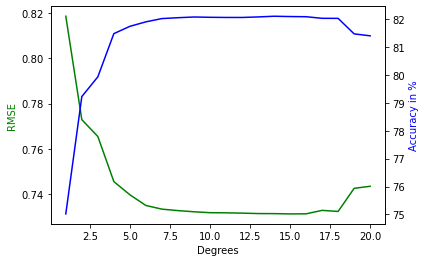

In [114]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
stop = 20

ax1.plot(degrees[:stop], rmses_LS_1[:stop], 'g-')
ax2.plot(degrees[:stop], accuracy_LS_1[:stop], 'b-')

ax1.set_xlabel('Degrees')
ax1.set_ylabel('RMSE', color='g')
ax2.set_ylabel('Accuracy in %', color='b')

print(rmses_LS_1)
print(accuracy_LS_1)

# We choose the degree 7, RMSE = 0.73339326, accuracy = 82.0172.
# The simplest model is preferred
# The best degree is 15.0   with RMSE =  0.7312868241811921 and accuracy =  82.09

In [113]:
#################
# Test LS on 20%
#################

degree = 7

param = { "model" : "LS" }

x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, 0.8, seed=1)

x_tr_p = build_poly(x_tr, degree)
x_te_p = build_poly(x_te, degree)


w, _ = least_squares(y_tr, x_tr_p)
accuracy = compute_accuracy(x_te_p, y_te, w, param)
rmse = np.sqrt(2 * compute_mse(y_te, x_te_p, w))

print("Test model : ", param["model"], "degree = ", degree, "accuracy = ", accuracy, "RMSE =", rmse)

# Test model :  LS degree =  7 accuracy =  81.93 RMSE = 0.7345786230861718


Test model :  LS degree =  7 accuracy =  81.93 RMSE = 0.7345786230861718


## GD optimization with CV + hyperparam optimization

In [115]:
########################################
# Ridge : CV + hyperparam optimization
########################################

degrees = np.linspace(6, 9, 4)
lambdas = np.logspace(-5, -2, 3)
k_fold = 5

parameters_ridge = {
  "model": "ridge",
  "param": lambdas,
}

rmses_ridge, accuracy_ridge = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_ridge, seed = 1)

# The best degree is 9.0  best parameter is 1e-05  with RMSE =  0.7322672580638763 and accuracy =  82.0684

Method =  ridge
Degree =  6.0
Progress :  0.0  % 
Degree =  7.0
Progress :  25.0  % 
Degree =  8.0
Progress :  50.0  % 
Degree =  9.0
Progress :  75.0  % 
The method used is :  ridge
The best degree is 9.0  best parameter is 1e-05  with RMSE =  0.7322672580638763 and accuracy =  82.0684


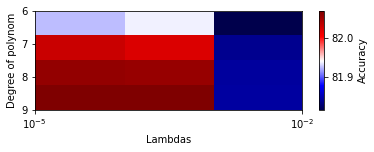

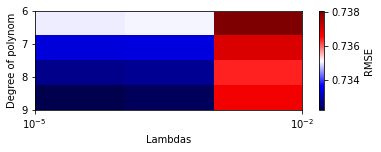

[[81.9244 81.938  81.814 ]
 [82.0312 82.0224 81.838 ]
 [82.0576 82.0564 81.8436]
 [82.0684 82.0676 81.8444]]
[[0.73503978 0.73508341 0.73802802]
 [0.73342017 0.73345633 0.73699243]
 [0.73278206 0.732839   0.73638903]
 [0.73226726 0.73239284 0.73671973]]


In [116]:
plt.subplot(211)
plt.imshow(accuracy_ridge, extent=[lambdas[0],lambdas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Lambdas')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'Accuracy')
plt.show()

plt.subplot(212)
plt.imshow(rmses_ridge, extent=[lambdas[0],lambdas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Lambdas')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'RMSE')
plt.show()

print(accuracy_ridge)
print(rmses_ridge)

# We choose degree 7, lambda = 0.01, RMSE = 0.73699243, accuracy = 81.838
# Even if it's not the smallest RMSE and the highest accuracy, we choose this simplest model


In [117]:
#################
# Test ridge on 20%
#################

degree = 7
lambda_ = 0.01


param = { "model": "ridge" }

x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, 0.8, seed=1)


x_tr_p = build_poly(x_tr, degree)
x_te_p = build_poly(x_te, degree)


w, _ = ridge_regression(y_tr, x_tr_p, lambda_)
accuracy = compute_accuracy(x_te_p, y_te, w, param)
rmse = np.sqrt(2 * compute_mse(y_te, x_te_p, w))

print("Test model : ", param["model"], "degree = ", degree, "accuracy = ", accuracy, "RMSE =", rmse)

# Test model :  ridge degree =  7 accuracy =  81.73 RMSE = 0.7380604198238125



Test model :  ridge degree =  7 accuracy =  81.73 RMSE = 0.7380604198238125


In [118]:
########################################
# LR : CV + hyperparam optimization
########################################
from proj1_helpers import *


degrees = np.linspace(2, 3, 2)
gammas = np.logspace(-6, -5, 2)
k_fold = 5
max_iters = 1000

parameters_LR = {
      "model": "LR",
      "param": [gammas, max_iters],
}

losses_LR, accuracy_LR = best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_LR, seed = 1)

# The best degree is 2.0  best parameter is 1e-06  with loss NLL =  0.4223787711781738 and accuracy =  81.008

Method =  LR
Degree =  2.0
Progress :  0.0  % 
Degree =  3.0
Progress :  50.0  % 


/Users/ines/Documents/SV/SV-MA3/ML_course/projects/project1/scripts/implementations.py:327: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-t))
/Users/ines/Documents/SV/SV-MA3/ML_course/projects/project1/scripts/implementations.py:277: RuntimeWarning: overflow encountered in exp
  loss = (np.sum(np.log(1 + np.exp(sigma))) - y.T @ sigma)/len(y)


The method used is :  LR
The best degree is 2.0  best parameter is 1e-06  with loss NLL =  0.4223787711781738 and accuracy =  81.008


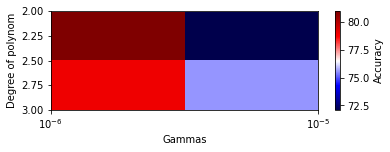

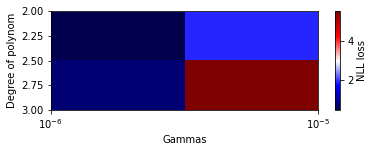

[[81.008  72.0916]
 [79.0356 75.6416]]
[[0.42237877 1.89109741]
 [0.72025305 5.55100773]]


In [119]:
plt.subplot(211)
plt.imshow(accuracy_LR, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gammas')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'Accuracy')
plt.show()

plt.subplot(212)
plt.imshow(losses_LR, extent=[gammas[0],gammas[-1], degrees[-1],degrees[0]],aspect = 'auto',cmap ='seismic')
plt.xlabel('Gammas')
plt.ylim([degrees[-1],degrees[0]])
plt.xscale('symlog')
plt.ylabel('Degree of polynom')
plt.colorbar(label = 'NLL loss')
plt.show()

print(accuracy_LR)
print(losses_LR)

In [120]:
#########
# Test LR
#########

degree = 2
gamma = 1e-6
max_iters = 1000


param = { "model": "LR" }

x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, 0.8, seed=1)


x_tr_p = build_poly(x_tr, degree)
x_te_p = build_poly(x_te, degree)

initial_w = np.zeros(x_tr_p.shape[1])


w, _ = logistic_regression(y_tr, x_tr_p, initial_w, max_iters, gamma)

accuracy = compute_accuracy(x_te_p, y_te, w, param) 


print("Test model : ", param["model"], "degree = ", degree, "param = ", gamma, "accuracy = ", accuracy)

# Test model :  LR degree =  2 param =  1e-06 accuracy =  80.946




Test model :  LR degree =  2 param =  1e-06 accuracy =  80.946


In [122]:
########################################
# REG_LR : CV + hyperparam optimization
########################################

degrees = np.linspace(2, 3, 2)
lambdas = np.logspace(-4, 0, 5)
gamma = 1e-6
k_fold = 5
max_iters = 500

parameters_REG_LR = {
      "model": "REG_LR",
      "param": [lambdas, max_iters, gamma],
}

losses_REG_LR, accuracy_REG_LR =  best_degree_selection(tX_post, y_post, degrees, k_fold, parameters_REG_LR, seed = 1)

# The best degree is 2.0  best parameter is 0.0001  with loss NLL =  0.4239793124184884 and accuracy =  80.9632

Method =  REG_LR
Degree =  2.0
Progress :  0.0  % 
Converged in :  85  iterations
Degree =  3.0
Progress :  50.0  % 
The method used is :  REG_LR
The best degree is 2.0  best parameter is 0.0001  with loss NLL =  0.4239793124184884 and accuracy =  80.9632


In [123]:
#################
# Test REG_LR on 20%
#################

degree = 2
gamma = 1e-6
max_iters = 1000
lambda_ = 1e-4


param = { "model": "REG_LR" }


x_tr, x_te, y_tr, y_te = split_data(tX_post, y_post, 0.8, seed=1)


x_tr_p = build_poly(x_tr, degree)
x_te_p = build_poly(x_te, degree)

initial_w = np.zeros(x_tr_p.shape[1])


w, _ = reg_logistic_regression(y_tr, x_tr_p, lambda_, initial_w, max_iters, gamma)

accuracy = compute_accuracy(x_te_p, y_te, w, param) 


print("Test model : ", param["model"], "degree = ", degree, "param = ", lambda_, "accuracy = ", accuracy)

# Test model :  REG_LR degree =  2 param =  0.0001 accuracy =  80.946





Test model :  REG_LR degree =  2 param =  0.0001 accuracy =  80.946


In [124]:
###################################################
# Test LS on 20%, according to jet categories
###################################################

from implementations import *

jet = categorizing(tX_pre)


parameters_LS = { "model": "LS" }

num_row = len(jet)
num_col = 1
accuracies_all = []


for i in range(len(jet)) :
    tX_jet = clear_variance_0(tX_post[jet[i]])
    print("jet :", i, "shape : ", tX_jet.shape)

    x_tr, x_te, y_tr, y_te = split_data(tX_jet, y_post[jet[i]], 0.8, seed=1)
    degrees = np.linspace(1, 20, 20)
    accuracies_d = []


    for d in degrees:

        # form data with polynomial degree:
        x_tr_p = build_poly(x_tr, d)
        x_te_p = build_poly(x_te, d)

        w_list, _ = least_squares(y_tr, x_tr_p)
        accuracies_d.append(compute_accuracy(x_te_p, y_te, w_list, parameters_LS))
        
    accuracies_all.append(accuracies_d)


jet : 0 shape :  (99913, 18)
jet : 1 shape :  (77544, 22)
jet : 2 shape :  (50379, 29)
jet : 3 shape :  (22164, 29)


85.05229445028274
80.72087175188601
83.26716951171099
84.07399052560342


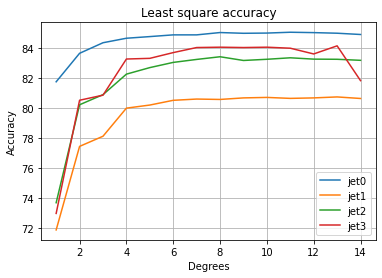

In [125]:
degrees = np.linspace(1, 20, 20)
stop = 14
d = [7, 9, 9, 9]
for i, acc in enumerate(accuracies_all):
    lab = "jet" + str(i)
    plt.plot(degrees[:stop], acc[:stop], label = lab)
    plt.xlabel("Degrees")
    plt.ylabel("Accuracy")
    plt.title("Least square accuracy")
    plt.legend() 
    plt.grid(True)
    print(acc[d[i]])


In [132]:
###################################################
# Test LS on 20%, globally
###################################################

x_tr, x_te, y_tr, y_te = split_data(tX_pre, y_pre, 0.8, seed=1)

# Split according to categories, feature PRI_jet_num
jet = categorizing(x_tr)
# Split according to categories, feature PRI_jet_num
jet_test = categorizing(x_te)

# Best parameters per category :
best_degrees = [7, 9, 9, 9]

ids_pred = []
predictions = []
tot_acc = 0
for i in range(len(jet)):

    degree = best_degrees[i]

    param = {
      "model": "LS",
    }
    
    # Preprocessing train
    tX_post = x_tr[jet[i]]
    tX_post = remove_categorical_feature(tX_post)
    tX_post = clear_variance_0(tX_post)
    tX_post = remove_aberrant_values(tX_post)
    tX_post, lim_min, lim_max = rescale_outliers(tX_post)
    tX_post, mean_tr , std_tr = standardize(tX_post)
    
    # Preprocessing train
    tX_test_post = x_te[jet_test[i]]
    tX_test_post = remove_categorical_feature(tX_test_post)
    tX_test_post = clear_variance_0(tX_test_post)
    tX_test_post = remove_aberrant_values(tX_test_post)
    
    # Rescale outliers
    tX_test_post, _, _ = rescale_outliers(tX_test_post, lim_min, lim_max)

    # Standardize
    tX_test_post, _, _ = standardize(tX_test_post,mean_tr,std_tr)
    y_jet = y_tr[jet[i]]
    y_jet2 = y_te[jet_test[i]]

    x_tr_p = build_poly(tX_post, degree)

    w, _ = least_squares(y_jet, x_tr_p)

    tX = build_poly(tX_test_post, degree)
    
    tot_acc += compute_accuracy(tX, y_jet2, w, param)/100*len(y_jet2)

print(tot_acc/len(y_te)*100)

# 82.816


82.816


In [126]:
###################################################
# CV ridge, according to jet categories
###################################################

jet = categorizing(tX_pre)

degrees = np.linspace(5, 9, 5)
lambdas = np.logspace(-3, -1, 3)
k_fold = 5

rmse_all_ridge = []
accuracy_all_ridge = []

for i in range(len(jet)):
    
    parameters_ridge = {
      "model": "ridge",
      "param": lambdas,
    }
    
    tX_jet = clear_variance_0(tX_post[jet[i]])
    y_jet = y_post[jet[i]]
    
    rmses_ridge, accuracy_ridge = best_degree_selection(tX_jet, y_jet, degrees, k_fold, parameters_ridge, seed = 1)
    
    rmse_all_ridge.append(rmses_ridge)
    accuracy_all_ridge.append(accuracy_ridge)

# LS

# jet 0 : 85.05229445028274 
# jet 1 : 80.72087175188601
# jet 2 : 83.26716951171099
# jet 3 : 84.07399052560342 

# jet 0 : 
# The best degree is 7.0, L=1e-2,  best parameter is 0.01  RMSE =  0.6818233872246648 and accuracy =  84.23280952857571
# jet 1 : 
# The best degree is 9.0, L=1e-3,  best parameter is 0.001  RMSE = 0.7540272 and accuracy = 80.73897343 
# jet 2 :
# The best degree is 9.0, L=1e-3,  best parameter is 0.001  with RMSE =  0.70978346 and accuracy =  83.44615385
# jet 3 :
# The best degree is 9.0, L=1e-3,  best parameter is 0.001  with RMSE =  0.71857477 and accuracy =  83.62815884

Method =  ridge
Degree =  5.0
Progress :  0.0  % 
Degree =  6.0
Progress :  20.0  % 
Degree =  7.0
Progress :  40.0  % 
Degree =  8.0
Progress :  60.0  % 
Degree =  9.0
Progress :  80.0  % 
The method used is :  ridge
The best degree is 7.0  best parameter is 0.01  with RMSE =  0.6818233872246648 and accuracy =  84.23280952857571
Method =  ridge
Degree =  5.0
Progress :  0.0  % 
Degree =  6.0
Progress :  20.0  % 
Degree =  7.0
Progress :  40.0  % 
Degree =  8.0
Progress :  60.0  % 
Degree =  9.0
Progress :  80.0  % 
The method used is :  ridge
The best degree is 9.0  best parameter is 0.001  with RMSE =  0.754027198416501 and accuracy =  80.7389734330668
Method =  ridge
Degree =  5.0
Progress :  0.0  % 
Degree =  6.0
Progress :  20.0  % 
Degree =  7.0
Progress :  40.0  % 
Degree =  8.0
Progress :  60.0  % 
Degree =  9.0
Progress :  80.0  % 
The method used is :  ridge
The best degree is 9.0  best parameter is 0.001  with RMSE =  0.7097834561249527 and accuracy =  83.44615384615383
Meth

In [127]:
###################################################
# CV ridge, jet 0
###################################################

degrees = np.linspace(6, 8, 3)
lambdas = np.logspace(-3, -1, 3)
k_fold = 5

parameters_ridge = {
      "model": "ridge",
      "param": lambdas,
    }
    
tX_jet = clear_variance_0(tX_post[jet[0]])
y_jet = y_post[jet[0]]

rmses_ridge_j0, accuracy_ridge_j0 = best_degree_selection(tX_jet, y_jet, degrees, k_fold, parameters_ridge, seed = 1)
# The best degree is 7.0  best parameter is 0.01  with RMSE =  0.6818233872246648 and accuracy =  84.23280952857571

Method =  ridge
Degree =  6.0
Progress :  0.0  % 
Degree =  7.0
Progress :  33.33333333333333  % 
Degree =  8.0
Progress :  66.66666666666666  % 
The method used is :  ridge
The best degree is 7.0  best parameter is 0.01  with RMSE =  0.6818233872246648 and accuracy =  84.23280952857571


In [128]:
###################################################
# CV ridge, jet 1
###################################################

degrees = np.linspace(6, 10, 5)
lambdas = np.logspace(-5, -2, 4)
k_fold = 5

parameters_ridge = {
      "model": "ridge",
      "param": lambdas,
    }
    
tX_jet = clear_variance_0(tX_post[jet[1]])
y_jet = y_post[jet[1]]

rmses_ridge_j1, accuracy_ridge_j1 = best_degree_selection(tX_jet, y_jet, degrees, k_fold, parameters_ridge, seed = 1)
# The best degree is 10.0  best parameter is 0.0001  with RMSE =  0.7534354637088851 and accuracy =  80.76089760123806
# We preferred degree = 9, acc = 80.73897343, rmse = 0.7540272, lambda = 1e-3

Method =  ridge
Degree =  6.0
Progress :  0.0  % 
Degree =  7.0
Progress :  20.0  % 
Degree =  8.0
Progress :  40.0  % 
Degree =  9.0
Progress :  60.0  % 
Degree =  10.0
Progress :  80.0  % 
The method used is :  ridge
The best degree is 10.0  best parameter is 0.0001  with RMSE =  0.7534354637362205 and accuracy =  80.76089760123806


In [129]:
###################################################
# CV ridge, jet 2
###################################################

degrees = np.linspace(6, 10, 5)
lambdas = np.logspace(-5, -2, 4)
k_fold = 5

parameters_ridge = {
      "model": "ridge",
      "param": lambdas,
    }
    
tX_jet = clear_variance_0(tX_post[jet[2]])
y_jet = y_post[jet[2]]

rmses_ridge_j2, accuracy_ridge_j2 = best_degree_selection(tX_jet, y_jet, degrees, k_fold, parameters_ridge, seed = 1)
# The best degree is 10.0  best parameter is 0.0001  with RMSE =  0.7091928050630797 and accuracy =  83.43424317617867
# as before, we choose degree = 9, rmse = 0.70978346, acc = 83.44615385, lambda = 1e-3

Method =  ridge
Degree =  6.0
Progress :  0.0  % 
Degree =  7.0
Progress :  20.0  % 
Degree =  8.0
Progress :  40.0  % 
Degree =  9.0
Progress :  60.0  % 
Degree =  10.0
Progress :  80.0  % 
The method used is :  ridge
The best degree is 10.0  best parameter is 0.0001  with RMSE =  0.7091928050630797 and accuracy =  83.43424317617867


In [130]:
###################################################
# CV ridge, jet 3
###################################################

degrees = np.linspace(6, 10, 5)
lambdas = np.logspace(-5, -2, 4)
k_fold = 5

parameters_ridge = {
      "model": "ridge",
      "param": lambdas,
    }
    
tX_jet = clear_variance_0(tX_post[jet[3]])
y_jet = y_post[jet[3]]

rmses_ridge_j3, accuracy_ridge_j3 = best_degree_selection(tX_jet, y_jet, degrees, k_fold, parameters_ridge, seed = 1)
# The best degree is 10.0  best parameter is 0.001  with RMSE =  0.718556098687005 and accuracy =  83.51985559566786
# d = 9, rmse = 0.71857477, param = 1e-3, acc = 83.62815884

Method =  ridge
Degree =  6.0
Progress :  0.0  % 
Degree =  7.0
Progress :  20.0  % 
Degree =  8.0
Progress :  40.0  % 
Degree =  9.0
Progress :  60.0  % 
Degree =  10.0
Progress :  80.0  % 
The method used is :  ridge
The best degree is 10.0  best parameter is 0.001  with RMSE =  0.718556098687005 and accuracy =  83.51985559566786


In [142]:
print(rmses_ridge_j3)
print(accuracy_ridge_j3)

[[0.72491343 0.72486371 0.72473176 0.72812063]
 [0.72173316 0.72163602 0.72140142 0.72581013]
 [0.72029052 0.72018251 0.72004474 0.72571356]
 [0.71881063 0.71858283 0.71857477 0.72679933]
 [0.71893036 0.7186119  0.7185561  0.72665784]]
[[83.14530686 83.19945848 83.2400722  83.13628159]
 [83.49277978 83.50180505 83.5198556  83.28519856]
 [83.48375451 83.47021661 83.50631769 83.24458484]
 [83.52888087 83.55144404 83.62815884 83.14981949]
 [83.54693141 83.6101083  83.5198556  83.13628159]]


In [131]:
###################################################
# Test ridge on 20%, globally
###################################################

x_tr, x_te, y_tr, y_te = split_data(tX_pre, y_pre, 0.8, seed=1)

# Split according to categories, feature PRI_jet_num
jet = categorizing(x_tr)
# Split according to categories, feature PRI_jet_num
jet_test = categorizing(x_te)

# Best parameters per category :
best_degrees = [7, 9, 9, 9]
best_lambdas = [1e-2, 1e-3, 1e-3, 1e-3]

ids_pred = []
predictions = []
tot_acc = 0
for i in range(len(jet)):

    degree = best_degrees[i]
    lambda_ = best_lambdas[i]

    param = {
      "model": "ridge",
      "param": lambda_,
    }
    
    # Preprocessing train
    tX_post = x_tr[jet[i]]
    tX_post = remove_categorical_feature(tX_post)
    tX_post = clear_variance_0(tX_post)
    tX_post = remove_aberrant_values(tX_post)
    tX_post, lim_min, lim_max = rescale_outliers(tX_post)
    tX_post, mean_tr , std_tr = standardize(tX_post)
    
    # Preprocessing train
    tX_test_post = x_te[jet_test[i]]
    tX_test_post = remove_categorical_feature(tX_test_post)
    tX_test_post = clear_variance_0(tX_test_post)
    tX_test_post = remove_aberrant_values(tX_test_post)

    tX_test_post, _, _ = rescale_outliers(tX_test_post, lim_min, lim_max)

    tX_test_post, _, _ = standardize(tX_test_post,mean_tr,std_tr)
    
    y_jet = y_tr[jet[i]]
    y_jet2 = y_te[jet_test[i]]

    x_tr_p = build_poly(tX_post, degree)

    w, _ = ridge_regression(y_jet, x_tr_p, lambda_)

    tX = build_poly(tX_test_post, degree)
    
    tot_acc += compute_accuracy(tX, y_jet2, w, param)/100*len(y_jet2)

print(tot_acc/len(y_te)*100)

# 82.794

82.794


## Generate predictions and save ouput in csv format for submission:

In [143]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '../data/sample-submission.csv' 
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)